## Process & group soil files

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import ternary

In [3]:
df_soilsnass = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/soiltexture_nass.csv', 
                       index_col=0, dtype={'depth_category':str, 'sgroup':str})
df_soilsnass.head()

,cokey,chkey,prcent,slope_r,slope,hzname,depth,awc,clay,silt,sand,OM,dbthirdbar,th33,bd,lat,lon,depth_category,texture,sgroup
0,19726639,57641565,50.0,25.0,35.0,A,0.0,0.13,13.5,19.5,67.0,0.75,1.52,17.2,-0.1568,32.462991,-86.709691,0.0,sandy loam,1
1,19726639,57641566,50.0,25.0,35.0,Bt1,8.0,0.15,42.5,29.7,27.8,0.25,1.48,35.0,-0.3352,32.462991,-86.709691,50.0,clay,4
2,19726639,57641567,50.0,25.0,35.0,Bt2,89.0,0.15,30.0,36.5,33.5,0.10,1.61,25.0,-0.2339,32.462991,-86.709691,100.0,clay loam,2
3,19726639,57641568,50.0,25.0,35.0,C,109.0,0.08,22.5,17.9,59.6,0.00,1.70,20.9,-0.1920,32.462991,-86.709691,150.0,sandy clay loam,1
4,19787444,57846824,40.0,1.0,1.0,H1,0.0,0.15,11.5,43.2,45.3,5.50,1.43,29.1,-0.2767,30.787262,-87.712913,0.0,loam,2


In [4]:
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', 
                         index_col=0, dtype={'site':str})
df_siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_filtered.csv', 
                            index_col=0, dtype={'site':str})
sites = set(df_siteyears.site)
df_sites = df_summary[df_summary.site.isin(sites)]
df_sites.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
6,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,2445.923794,6.585904
7,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,10052.406880,5.735219
9,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,9510.127270,13.348148
10,722170,1,MACON MIDDLE GA REGIONAL AP,GA,-5,32.683,-83.650,22,2731.632292,18.039572
11,722180,1,AUGUSTA BUSH FIELD,GA,-5,33.367,-81.967,18,5940.794366,8.403471


In [136]:
#df_soils = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/soiltexture.csv', 
#                       index_col=0, dtype={'site': str, 'sgroup': str})
#df_soils.head()

### Add soil category into sites info:
Questions: 
1. What to do with sites that don't have soil query info? <br/>
    - Total of 22 sites that don't have soil info
    - Adopt soil texture of nearest site?
    - Average soil texture if the nearest 3 sites?
2. What to do with depth?
    - Can I just assume that soil properties are all the same at different depth?
    - And maybe just assign uniform depth to all locaitons? 
    - 5 layers: 0, 0-50, 50-100, 100-150, 150+

#### Assign soil class for each location after averaging soil composition across all depth:

In [7]:
df_sites.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
6,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,2445.923794,6.585904
7,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,10052.406880,5.735219
9,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,9510.127270,13.348148
10,722170,1,MACON MIDDLE GA REGIONAL AP,GA,-5,32.683,-83.650,22,2731.632292,18.039572
11,722180,1,AUGUSTA BUSH FIELD,GA,-5,33.367,-81.967,18,5940.794366,8.403471


In [8]:
df_soilsnass.head()

,cokey,chkey,prcent,slope_r,slope,hzname,depth,awc,clay,silt,sand,OM,dbthirdbar,th33,bd,lat,lon,depth_category,texture,sgroup
0,19726639,57641565,50.0,25.0,35.0,A,0.0,0.13,13.5,19.5,67.0,0.75,1.52,17.2,-0.1568,32.462991,-86.709691,0.0,sandy loam,1
1,19726639,57641566,50.0,25.0,35.0,Bt1,8.0,0.15,42.5,29.7,27.8,0.25,1.48,35.0,-0.3352,32.462991,-86.709691,50.0,clay,4
2,19726639,57641567,50.0,25.0,35.0,Bt2,89.0,0.15,30.0,36.5,33.5,0.10,1.61,25.0,-0.2339,32.462991,-86.709691,100.0,clay loam,2
3,19726639,57641568,50.0,25.0,35.0,C,109.0,0.08,22.5,17.9,59.6,0.00,1.70,20.9,-0.1920,32.462991,-86.709691,150.0,sandy clay loam,1
4,19787444,57846824,40.0,1.0,1.0,H1,0.0,0.15,11.5,43.2,45.3,5.50,1.43,29.1,-0.2767,30.787262,-87.712913,0.0,loam,2


(-5.0, 105.0, -10.0, 90.0)

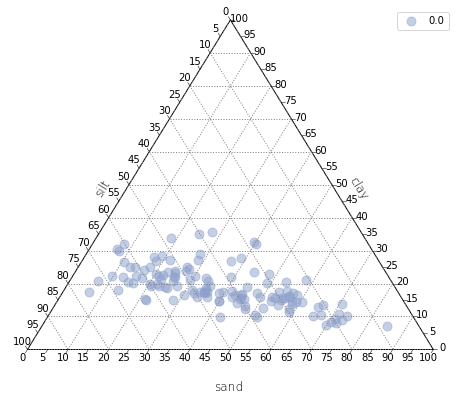

In [92]:
sites = df_sites.site
depth = '0.0'

df_soils_depth = df_soilsnass[df_soilsnass.depth_category == depth].dropna()

sands = []
silts = []
clays = []

for site in sites:
    lat = float(df_sites[df_sites.site == site].lat)
    lon = float(df_sites[df_sites.site == site].lon)
    dist = list(enumerate(np.sqrt((lat - df_soils_depth.lat)**2 + (lon - (df_soils_depth.lon))**2)))
    df_dist = pd.DataFrame(dist, columns=['rownum', 'distance'])
    row = list(df_dist.nsmallest(10, 'distance').rownum) # select the five nearest locations and average for
                                                        # mean surface soil info
    sand = df_soils_depth.iloc[row].sand.mean().round(2)
    silt = df_soils_depth.iloc[row].silt.mean().round(2)
    clay = df_soils_depth.iloc[row].clay.mean().round(2)
    sands.append(sand)
    silts.append(silt)
    clays.append(clay)

points = []
for i in range(len(sands)):
    sand = sands[i]
    clay = clays[i]
    silt = silts[i]
    points.append((sand, clay, silt))

scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(8,7)
tax.scatter(points, color='#8da0cb', s=80, alpha=0.5, label=depth)
tax.left_axis_label('silt', fontsize=12, fontweight='light')
tax.right_axis_label('clay', fontsize=12, fontweight='light')
tax.bottom_axis_label('sand', fontsize=12, fontweight='light')
tax.legend()

tax.boundary(linewidth=1)
tax.gridlines(multiple=10, linewidth=1, color='grey')
tax.ticks(axis='lbr', linewidth=0.5, multiple=5)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

(-5.0, 105.0, -10.0, 90.0)

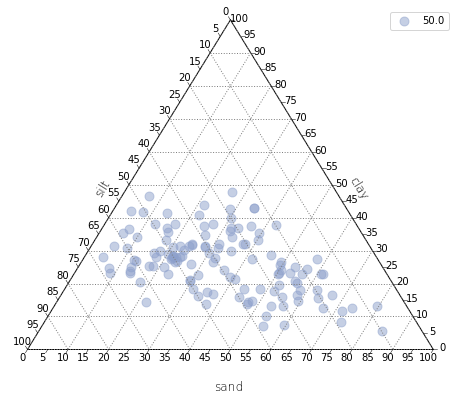

In [93]:
sites = df_sites.site
depth = '50.0'
df_soils_depth = df_soilsnass[df_soilsnass.depth_category == depth].dropna()

sands = []
silts = []
clays = []

for site in sites:
    lat = float(df_sites[df_sites.site == site].lat)
    lon = float(df_sites[df_sites.site == site].lon)
    dist = list(enumerate(np.sqrt((lat - df_soils_depth.lat)**2 + (lon - (df_soils_depth.lon))**2)))
    df_dist = pd.DataFrame(dist, columns=['rownum', 'distance'])
    row = list(df_dist.nsmallest(10, 'distance').rownum) # select the five nearest locations and average for
                                                        # mean surface soil info
    sand = df_soils_depth.iloc[row].sand.mean().round(2)
    silt = df_soils_depth.iloc[row].silt.mean().round(2)
    clay = df_soils_depth.iloc[row].clay.mean().round(2)
    sands.append(sand)
    silts.append(silt)
    clays.append(clay)

points = []
for i in range(len(sands)):
    sand = sands[i]
    clay = clays[i]
    silt = silts[i]
    points.append((sand, clay, silt))

scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(8,7)
tax.scatter(points, color='#8da0cb', s=80, alpha=0.5, label=depth)
tax.left_axis_label('silt', fontsize=12, fontweight='light')
tax.right_axis_label('clay', fontsize=12, fontweight='light')
tax.bottom_axis_label('sand', fontsize=12, fontweight='light')
tax.legend()

tax.boundary(linewidth=1)
tax.gridlines(multiple=10, linewidth=1, color='grey')
tax.ticks(axis='lbr', linewidth=0.5, multiple=5)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

(-5.0, 105.0, -10.0, 90.0)

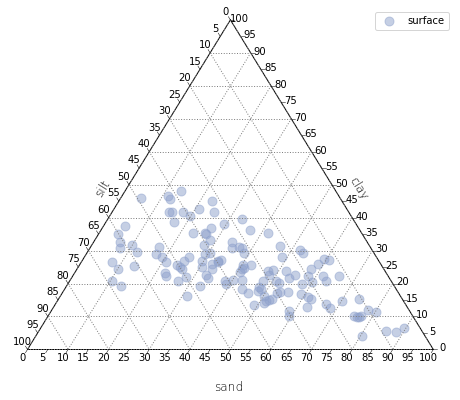

In [61]:
sites = df_sites.site
df_soils_depth = df_soilsnass[df_soilsnass.depth_category == '100.0'].dropna()

sands = []
silts = []
clays = []

for site in sites:
    lat = float(df_sites[df_sites.site == site].lat)
    lon = float(df_sites[df_sites.site == site].lon)
    dist = list(enumerate(np.sqrt((lat - df_soils_depth.lat)**2 + (lon - (df_soils_depth.lon))**2)))
    df_dist = pd.DataFrame(dist, columns=['rownum', 'distance'])
    row = list(df_dist.nsmallest(5, 'distance').rownum) # select the five nearest locations and average for
                                                        # mean surface soil info
    sand = df_soils_depth.iloc[row].sand.mean().round(2)
    silt = df_soils_depth.iloc[row].silt.mean().round(2)
    clay = df_soils_depth.iloc[row].clay.mean().round(2)
    sands.append(sand)
    silts.append(silt)
    clays.append(clay)

points = []
for i in range(len(sands)):
    sand = sands[i]
    clay = clays[i]
    silt = silts[i]
    points.append((sand, clay, silt))

scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(8,7)
tax.scatter(points, color='#8da0cb', s=80, alpha=0.5, label='surface')
tax.left_axis_label('silt', fontsize=12, fontweight='light')
tax.right_axis_label('clay', fontsize=12, fontweight='light')
tax.bottom_axis_label('sand', fontsize=12, fontweight='light')
tax.legend()

tax.boundary(linewidth=1)
tax.gridlines(multiple=10, linewidth=1, color='grey')
tax.ticks(axis='lbr', linewidth=0.5, multiple=5)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

In [113]:
# average soil info across depth for each site
df_soils_sites = df_soils.groupby(['site']).mean()

# set up boundaries for 10 soil classes & 4 soil groups
sand_min = [80,50,30,0,50,0,20,50,0,0]
sand_max = [100,80,50,50,80,30,50,70,20,50]
silt_min = [0,0,30,50,0,50,20,0,50,0]
silt_max = [20,50,50,100,30,80,50,20,70,50]
clay_min = [0,0,0,0,20,20,20,30,30,30]
clay_max = [20,20,20,20,30,30,30,50,50,100]
texture_class = ['sand', 'sandy loam', 'loam', 'silt loam', 'sandy clay loam', 
                 'silty clay loam', 'clay loam', 'sandy clay', 'silty clay', 'clay']
sgroup = [1, 1, 2, 3, 1, 3, 2, 1, 3, 4]

# create texture table
df_texture = pd.DataFrame({'sand_min': sand_min,
                           'sand_max': sand_max,
                           'silt_min': silt_min, 
                           'silt_max': silt_max,
                           'clay_min': clay_min, 
                           'clay_max': clay_max,
                           'texture': texture_class,
                           'sgroup': sgroup})

# assign soil group for each location based on averaged soil profile across depth
sgroups = []
for i in list(df_soils_sites.index):
    sand = df_soils_sites.loc[i,'sand']
    silt = df_soils_sites.loc[i,'silt']
    clay = df_soils_sites.loc[i,'clay']

    sgroup = df_texture[
        (sand > df_texture.sand_min) & (sand <= df_texture.sand_max) & 
        (silt > df_texture.silt_min) & (silt <= df_texture.silt_max) & 
        (clay > df_texture.clay_min) & (clay <= df_texture.clay_max)].sgroup.values[0]
    sgroups.append(sgroup)

df_soils_sites['sgroup'] = sgroups
print(df_soils_sites.shape)
df_soils_sites.head()

(108, 18)


,cokey,chkey,prcent,slope_r,slope,depth,awc,clay,silt,sand,OM,dbthirdbar,th33,bd,lat,lon,depth_category,sgroup
site,,,,,,,,,,,,,,,,,,
722070,19699452.0,57590014.5,30.0,45.0,80.0,27.250000,0.055000,12.250000,32.250000,55.500000,1.1875,1.430000,12.425000,-0.109950,37.583,-83.317,62.500000,1
722140,20289055.0,59531495.0,55.0,4.0,5.0,49.000000,0.106667,21.833333,11.800000,66.366667,0.2500,1.510000,21.566667,-0.200567,32.517,-84.950,66.666667,1
722170,20460021.0,60077457.5,90.0,1.0,2.0,9.000000,0.220000,17.000000,60.500000,22.500000,1.2500,1.280000,25.900000,-0.246200,42.383,-96.383,25.000000,3
722180,19907636.0,58301570.0,55.0,30.0,50.0,0.000000,0.140000,17.000000,17.900000,65.100000,0.2500,1.480000,16.700000,-0.152200,35.433,-82.533,0.000000,1
722230,20438620.0,60006147.0,40.0,7.0,10.0,49.666667,0.073333,3.666667,4.333333,92.000000,0.5000,1.526667,9.766667,-0.082400,41.700,-86.333,66.666667,1


#### Address sites with no soil info:

In [132]:
df_sites_nosoil = df_sites[~df_sites.site.isin(set(df_soils.site))]
print('sites with no soil info:', df_sites_nosoil.shape[0])

sites with no soil info: 22


In [130]:
df_sites = df_sites.merge(df_soils_sites.sgroup, how='left', left_on='site', right_on=df_soils_sites.sgroup.index)
# **create another df that's not named df_sites or just stick to df_sites and overwrite it?

In [133]:
df_sites.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri,sgroup
0,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,2445.923794,6.585904,1.0
1,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,10052.406880,5.735219,NaN
2,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,9510.127270,13.348148,1.0
3,722170,1,MACON MIDDLE GA REGIONAL AP,GA,-5,32.683,-83.650,22,2731.632292,18.039572,3.0
4,722180,1,AUGUSTA BUSH FIELD,GA,-5,33.367,-81.967,18,5940.794366,8.403471,1.0


### Calcualte sand/silt/clay content for each soil group:

In [42]:
df_soils.groupby(['sgroup']).mean()[['clay','silt','sand','OM','dbthirdbar','th33']]

,clay,silt,sand,OM,dbthirdbar,th33
sgroup,,,,,,
1,9.357983,13.052941,77.589076,1.079664,1.482521,14.578151
2,24.331915,39.504255,36.163830,2.454255,1.564894,26.859574
3,23.867424,64.555303,11.577273,3.318333,1.359015,29.485606
4,44.057317,38.873171,17.069512,2.006098,1.398780,33.759756


In [22]:
df_sites

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
6,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,2445.923794,6.585904
7,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,10052.406880,5.735219
9,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,9510.127270,13.348148
10,722170,1,MACON MIDDLE GA REGIONAL AP,GA,-5,32.683,-83.650,22,2731.632292,18.039572
11,722180,1,AUGUSTA BUSH FIELD,GA,-5,33.367,-81.967,18,5940.794366,8.403471
...,...,...,...,...,...,...,...,...,...,...
193,727450,1,DULUTH INTERNATIONAL ARPT,MN,-6,46.833,-92.217,24,3366.989685,0.872252
195,727530,1,FARGO HECTOR INTERNATIONAL AP,ND,-6,46.933,-96.817,25,28514.194400,0.610868
196,727640,1,BISMARCK MUNICIPAL ARPT [ISIS],ND,-7,46.767,-100.750,22,4977.641160,1.393164
204,727810,1,YAKIMA AIR TERMINAL,WA,-8,46.567,-120.550,25,5592.764148,45.433900


### Closer look at soil profile for each site:
- Looking at results, it probably makes sense to just have all depths be the same soil category?
- Also, maybe the deeper soil layers are not as important?
- They're probably still important for water transport, but how deep do maize roots get?

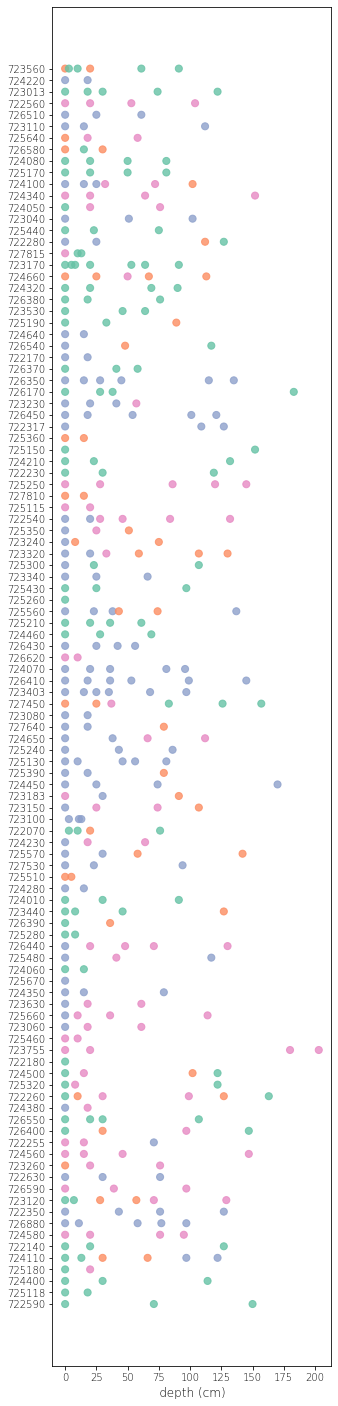

In [5]:
colors = {1:'#66c2a5', 2:'#fc8d62', 3:'#8da0cb', 4:'#e78ac3'}

fig, ax = plt.subplots(figsize=(5,25))
ax.scatter(df_soils.depth, df_soils.site, 
           c=df_soils.sgroup.map(colors), alpha=0.8, s=50)
ax.set_xlabel('depth (cm)', fontweight='light', size=12)
plt.xticks(fontweight='light')
plt.yticks(fontweight='light')
plt.show()

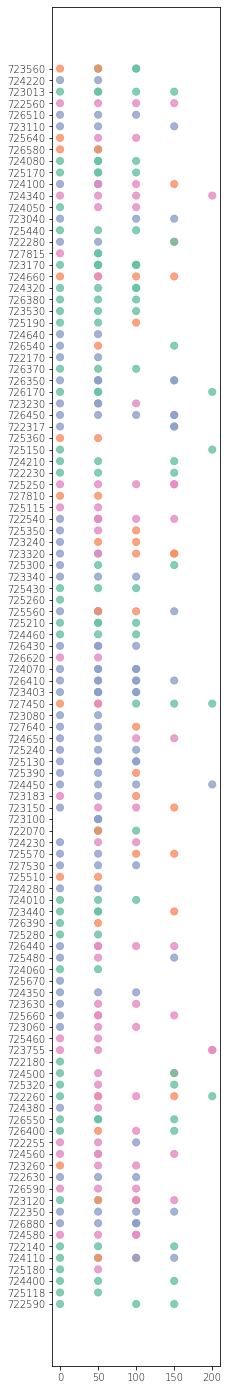

In [6]:
colors = {1:'#66c2a5', 2:'#fc8d62', 3:'#8da0cb', 4:'#e78ac3'}

fig, ax = plt.subplots(figsize=(3,25))
ax.scatter(df_soils.depth_category, df_soils.site, 
           c=df_soils.sgroup.map(colors), alpha=0.8, s=50)
plt.xticks(fontweight='light')
plt.yticks(fontweight='light')
plt.show()